In [1]:
import pandas as pd
import numpy as np
import pycountry
import re
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
import joblib
from computing_centroids import compute_centroids
import pickle

from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import country_converter as coco
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jahandelestangjim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Clean and prepare the data

In [5]:
data=pd.read_csv('un_general_debates_extended.csv', index_col=0)
cc = coco.CountryConverter()
country_name_short=data['country_name_short']
un_region_names = cc.convert(names = country_name_short, to = 'UNregion')

data.loc[:,'UN_region']=un_region_names

# convert text data to lower case (for easier analysis)
data.loc[:,'clean_text'] = data['text'].str.lower()
# Remove unusual symbols from description
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    # Remove things between brackets
    cleaned = re.sub("\[.*?\]", " ", cleaned)

    return cleaned.strip()

# clean text
data.loc[:,'clean_text'] = data.clean_text.apply(lambda x: clean(x))
# remove data with null value in year column
data = data[data['year'].notnull()]


In [6]:
data

,country,text,year,country_name_short,UN_region,clean_text
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile,South America,i shall occupy this rostrum for a few minutes ...
1,COL,The Colombian delegation does not consider it ...,1946,Colombia,South America,the colombian delegation does not consider it ...
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus,Eastern Europe,as more than a year has elapsed since the unit...
3,IND,I stand before this great Assembly — unique in...,1946,India,Southern Asia,i stand before this great assembly unique in...
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"in his great pronouncement here the other day,..."
...,...,...,...,...,...,...
10563,GAB,"It is my pleasant duty to offer you, Mr. Presi...",1963,Gabon,Middle Africa,"it is my pleasant duty to offer you, mr presi..."
10564,TCD,"It Is not without a certain pride, mixed with ...",1963,Chad,Middle Africa,"it is not without a certain pride, mixed with ..."
10565,COL,"Colombia, and the delegation which represents ...",1963,Colombia,South America,"colombia, and the delegation which represents ..."
10566,TUN,"Mr. President, it is a pleasure for me first o...",1963,Tunisia,Northern Africa,"mr president, it is a pleasure for me first o..."


In [7]:
from nltk.tokenize import ToktokTokenizer
import string
from sklearn.feature_extraction import text
from functools import reduce
import pandas as pd
import unicodedata
import sys

tk = ToktokTokenizer()
# For replacement of contractions.
contractions = {"you'd": 'you would', "he'd": 'he would', "she's": 'she is', "where'd": 'where did', "might've": 'might have', "he'll": 'he will', "they'll": 'they will',  "mightn't": 'might not', "you'd've": 'you would have', "shan't": 'shall not', "it'll": 'it will', "mayn't": 'may not', "couldn't": 'could not', "they'd": 'they would', "so've": 'so have', "needn't've": 'need not have', "they'll've": 'they will have', "it's": 'it is', "haven't": 'have not', "didn't": 'did not', "y'all'd": 'you all would', "needn't": 'need not', "who'll": 'who will', "wouldn't've": 'would not have', "when's": 'when is', "will've": 'will have', "it'd've": 'it would have', "what'll": 'what will', "that'd've": 'that would have', "y'all're": 'you all are', "let's": 'let us', "where've": 'where have', "o'clock": 'oclock', "when've": 'when have', "what're": 'what are', "should've": 'should have', "you've": 'you have', "they're": 'they are', "aren't": 'are not', "they've": 'they have', "it'd": 'it would', "i'll've": 'i will have', "they'd've": 'they would have', "you'll've": 'you will have', "wouldn't": 'would not', "we'd": 'we would', "hadn't've": 'had not have', "weren't": 'were not', "i'd": 'i would', "must've": 'must have', "what's": 'what is', "mustn't've": 'must not have', "what'll've": 'what will have', "ain't": 'aint', "doesn't": 'does not', "we'll": 'we will', "i'd've": 'i would have', "we've": 'we have', "oughtn't": 'ought not', "you're": 'you are', "who'll've": 'who will have', "shouldn't": 'should not', "can't've": 'cannot have', "i've": 'i have', "couldn't've": 'could not have', "why've": 'why have', "what've": 'what have', "can't": 'cannot', "don't": 'do not', "that'd": 'that would', "who's": 'who is', "would've": 'would have', "there'd": 'there would', "shouldn't've": 'should not have', "y'all": 'you all', "mustn't": 'must not', "she'll": 'she will', "hadn't": 'had not', "won't've": 'will not have', "why's": 'why is', "'cause": 'because', "wasn't": 'was not', "shan't've": 'shall not have', "ma'am": 'madam', "hasn't": 'has not', "to've": 'to have', "how'll": 'how will', "oughtn't've": 'ought not have', "he'll've": 'he will have', "we'd've": 'we would have', "won't": 'will not', "could've": 'could have', "isn't": 'is not', "she'll've": 'she will have', "we'll've": 'we will have', "you'll": 'you will', "who've": 'who have', "there's": 'there is', "y'all've": 'you all have', "we're": 'we are', "i'll": 'i will', "i'm": 'i am', "how's": 'how is', "she'd've": 'she would have', "sha'n't": 'shall not', "there'd've": 'there would have', "he's": 'he is', "it'll've": 'it will have', "that's": 'that is', "y'all'd've": 'you all would have', "he'd've": 'he would have', "how'd": 'how did', "where's": 'where is', "so's": 'so as', "she'd": 'she would', "mightn't've": 'might not have'}
un_stopwords = ['nations','year','believe','important','assembly','secretary',
                'conference', 'like', 'way', 'state', 'resolution', 
                'government', 'make', 'role', 
                'united nation', 'united nations', 'general assembly', 'republic of', 'secretary general', 'the world', 
                'ibid', 'security council', 'member state', 'country', 'must', 'many'] + list(text.ENGLISH_STOP_WORDS)

def tokenize_text(text, stopwords=un_stopwords):
    text = reduce(lambda a, kv: a.replace(*kv), contractions.items(), text.lower())
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    tokens = tk.tokenize(text)
    
    tokens = [token for token in tokens if len(token) > 3 and
             token not in stopwords and not token.isdigit()]
    
    #remove inflectional endings and get the root word (lemma):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmas

data['clean_text'] = data['clean_text'].apply(tokenize_text)

In [8]:
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess

# Create a Phrases model to detect common bigrams
bigram_model = Phrases(data['clean_text'].values, min_count=3, threshold=2)

# Convert the bigrams into single tokens
phraser = Phraser(bigram_model)
processed_sentences = [phraser[sentence] for sentence in data['clean_text'].values]
data['clean_text']=processed_sentences
data.to_csv('un_general_debates_extended_cleaned.csv')

In [42]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

# Sample dataset - a list of documents
documents = data['clean_text'].values
documents = [" ".join(sublist) for sublist in documents]

# Create your representation model
representation_model = MaximalMarginalRelevance(diversity=0.3)

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model, nr_topics="auto")

# Fit the model on the dataset
topics, probabilities = topic_model.fit_transform(documents)
new_topics = topic_model.reduce_outliers(documents, topics, probabilities=probabilities, strategy="probabilities")

topic_model.update_topics(documents, topics=new_topics)


2024-05-05 20:16:28,313 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [43]:
# Get the topics and display them
print("Topics and their frequency:")
topic_freq = topic_model.get_topic_info()
print(topic_freq)

# Display the words associated with each topic
for topic_id in topic_freq['Topic']:
    topic_details = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id}:")
    print(topic_details)

Topics and their frequency:
    Topic  Count                                               Name  \
0       0   9004                      0_united_world_people_country   
1       1     54                     1_lebanon_lebanese_israel_arab   
2       2     51                   2_colombia_colombian_world_peace   
3       3     50  3_guatemala_guatemalan_centralamerican_central...   
4       4     49                4_yemen_yemeni_people_republicyemen   
5       5     47     5_burundi_peopleburundi_republicburundi_people   
6       6     47                    6_brazil_brazilian_united_world   
7       7     47             7_romania_state_romanian_international   
8       8     47              8_panama_panamanian_canal_panamacanal   
9       9     39                     9_canada_canadian_united_world   
10     10     39                   10_fiji_tonga_fijian_smallisland   
11     11     39                    11_italy_italian_united_problem   
12     12     38                12_ukraine_russia

In [44]:
topics_to_merge = [[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 26, 28, 29, 30, 31, 34, 35, 36, 39, 42, 43, 44, 45, 47, 48, 49, 50, 51],
                    [0, 5, 24, 25, 32, 33, 38, 41, 46, 52, 53, 54],
                     [ 10, 14, 22, 27, 37, 40, 52, 55, 56],
                     [ 17, 32, 37, 41, 53],
                      [ 3, 16, 23, 33, 37, 43, 45, 46]]
topic_model.merge_topics(documents, topics_to_merge)

1. International Relations and Geopolitics
Topics that cover international diplomacy, geopolitics, and regional cooperation.
Topics: 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 26, 28, 29, 30, 31, 34, 35, 36, 39, 42, 43, 44, 45, 47, 48, 49, 50, 51

2. Human Rights and Social Justice
Topics focusing on human rights, social justice, and humanitarian efforts.
Topics: 0, 5, 24, 25, 32, 33, 38, 41, 46, 52, 53, 54

3. Development and Economy
Topics related to economic development, sustainability, and international cooperation.
Topics: 10, 14, 22, 27, 37, 40, 52, 55, 56

4. Environmental Sustainability and Climate Change
Topics that emphasize climate change, environmental sustainability, and small island nations.
Topics: 17, 32, 37, 41, 53

5. Culture and Heritage
Topics centered around cultural heritage, traditional practices, and national identity.
Topics: 3, 16, 23, 33, 37, 43, 45, 46


In [45]:
# Get the topics and display them
print("Topics and their frequency:")
topic_freq = topic_model.get_topic_info()
print(topic_freq)

# Display the words associated with each topic
for topic_id in topic_freq['Topic']:
    topic_details = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id}:")
    print(topic_details)

Topics and their frequency:
   Topic  Count                                      Name  \
0      0   9141             0_united_world_people_country   
1      1    930       1_united_world_people_international   
2      2    189  2_trinidadtobago_united_development_fiji   
3      3    186            3_guatemala_united_iraq_people   
4      4    110          4_cuba_unitedstate_people_united   

                                      Representation  \
0  [united, world, people, country, international...   
1  [united, world, people, international, peace, ...   
2  [trinidadtobago, united, development, fiji, wo...   
3  [guatemala, united, iraq, people, azerbaijan, ...   
4  [cuba, unitedstate, people, united, world, gre...   

                                 Representative_Docs  
0  [convey_president gaston_thorn greeting ecuado...  
1  [president occasion_election president forum s...  
2  [greatly_honored address rostrum_convey presid...  
3  [allowed extend_behalf delegation_guatemala w

In [48]:
topic_model.set_topic_labels({0: "International Relations and Geopolitics", 1: 'Human Rights and Social Justice', 
                              2: 'Economy', 3:'Climate Change', 4:"Culture"})


In [53]:
data['topics']=topic_model.get_document_info(documents)['CustomName']
data.to_csv('un_general_debates_extended_cleaned_topics.csv')


## Read from there

In [6]:
data=pd.read_csv('un_general_debates_extended_cleaned.csv', index_col=0)
data['clean_text'] = data['clean_text'].apply(ast.literal_eval)


## Group the data with tags

In [ ]:
grouped_df=data.groupby('year')['clean_text'].apply(sum).reset_index()
dict_tag_grouped_text = dict(zip(grouped_df['year'], grouped_df['clean_text']))
data.loc[:,'clean_text_merged'] = data['year'].map(lambda x: dict_tag_grouped_text.get(x, None))
data_year=data[['year', 'clean_text_merged']]
data_year.drop_duplicates(subset=['year'], keep='first', inplace=True)
data_year.reset_index(drop=True, inplace=True)

/tmp/ipykernel_553/1274530912.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_df=data.groupby('year')['clean_text'].apply(sum).reset_index()
/tmp/ipykernel_553/1274530912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year.drop_duplicates(subset=['year'], keep='first', inplace=True)


## Average similarity of each word embedding with seed vector 

Here we first compute the centroids of each list of seed words, then of each speech, and look at the cosine similarity of each speech with the c_territorial and c_functional. Similar to Daniele 

In [49]:
data_year=data
data_year['clean_text_merged']=data_year['clean_text']

### With Word2Vec

In [13]:

sentences = data_year['clean_text_merged'].values
model = Word2Vec(sentences, vector_size=200, min_count=1, window=20, sg=1)
fname = f"word2vec_whole_corpus_year_country.model"
model.save(fname)

# Create an empty dictionary for word frequencies
word_freq = {}

# Count word frequencies
for sentence in sentences:
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1  # Increment count if the word is already in the dictionary
        else:
            word_freq[word] = 1  # Initialize count for new words

# Path to save the pickle file
pickle_file_path = 'wordscount_preprocess.pkl'

# Open the file in write-binary mode and save the dictionary
with open(pickle_file_path, 'wb') as f:
    pickle.dump(word_freq, f)

In [14]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"word2vec_whole_corpus_year_country.model"

w2v = Word2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess.pkl')

c_territorial=compute_centroids(w2v, territorial_terms, words_frequency)
c_functional=compute_centroids(w2v, functional_terms, words_frequency)

100%|██████████| 179902/179902 [00:00<00:00, 3065288.50it/s]


In [15]:
territoriality=[]
functionality=[]
centroids=[]
for speech in data_year['clean_text_merged'].values:
    speech_centroid= compute_centroids(w2v, speech, words_frequency)
    similarity_territorial = cosine_similarity(speech_centroid, c_territorial)[0][0]
    similarity_functional= cosine_similarity(speech_centroid, c_functional)[0][0]

    territoriality.append(similarity_territorial)
    functionality.append(similarity_functional)
    centroids.append(speech_centroid)

100%|██████████| 179902/179902 [00:00<00:00, 2655147.38it/s]


In [16]:
data_year['territoriality_w2v_centroid']=territoriality
data_year['speech_w2v_centroid']=centroids
data_year['functionality_w2v_centroid']=functionality

In [48]:
data_year['territoriality_normalized']=data_year['territoriality_w2v_centroid']/max(data_year['territoriality_w2v_centroid'])
data_year['functionality_normalized']=data_year['functionality_w2v_centroid']/max(data_year['functionality_w2v_centroid'])
data_year.to_csv('data_year_country_with_w2v_centroids_backup.csv')

In [3]:
import pandas as pd
import numpy as np

data_year=pd.read_csv('data_year_country_with_w2v_centroids_backup.csv', index_col=0)

In [4]:
data_1_decade=data_year[data_year['year']<=1956]
data_1_decade['tag']=(data_1_decade['year']).astype(str)+'_'+data_1_decade['country_name_short']
data_1_decade=data_1_decade[['tag', 'territoriality_w2v_centroid', 'functionality_w2v_centroid', 'text']]
data_1_decade=data_1_decade.sort_values(by=['territoriality_w2v_centroid'])

/tmp/ipykernel_12647/1013629035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_decade['tag']=(data_1_decade['year']).astype(str)+'_'+data_1_decade['country_name_short']


In [5]:
# Initialize an empty list to hold the rows
rows = []

# Iterate over the range (0, 5)
for i in range(0, 5):
    rows.append(data_1_decade.iloc[i])
    rows.append(data_1_decade.iloc[len(data_1_decade) - 1 - i])

# Create a new DataFrame from the selected rows
data_1_decade_most_territorial_least_territorial = pd.DataFrame(rows)
#rang impair + territorial que rang pair 

In [13]:
def create_df_territoriality_pairs(data_decade):
    data_decade['tag']=(data_decade['year']).astype(str)+'_'+data_decade['country_name_short']
    data_decade=data_decade[['tag', 'territoriality_w2v_centroid', 'functionality_w2v_centroid', 'text']]
    data_decade=data_decade.sort_values(by=['territoriality_w2v_centroid'])
    # Initialize an empty list to hold the rows
    rows = []

    # Iterate over the range (0, 5)
    for i in range(0, 10):
        rows.append(data_decade.iloc[i])
        rows.append(data_decade.iloc[len(data_decade) - 1 - i])

    # Create a new DataFrame from the selected rows
    data_decade_most_territorial_least_territorial = pd.DataFrame(rows)
    #rang impair + territorial que rang pair 
    return data_decade_most_territorial_least_territorial

In [14]:
data_2_decade=data_year[data_year['year']<=1966]
data_2_decade=data_2_decade[data_2_decade['year']>1956]
data_2_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_2_decade)

data_3_decade=data_year[data_year['year']<=1976]
data_3_decade=data_3_decade[data_3_decade['year']>1966]
data_3_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_3_decade)

data_4_decade=data_year[data_year['year']<=1986]
data_4_decade=data_4_decade[data_4_decade['year']>1976]
data_4_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_4_decade)

data_5_decade=data_year[data_year['year']<=1996]
data_5_decade=data_5_decade[data_5_decade['year']>1986]
data_5_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_5_decade)

data_6_decade=data_year[data_year['year']<=2006]
data_6_decade=data_6_decade[data_6_decade['year']>1996]
data_6_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_6_decade)

data_7_decade=data_year[data_year['year']<=2016]
data_7_decade=data_7_decade[data_7_decade['year']>2006]
data_7_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_7_decade)

data_8_decade=data_year[data_year['year']<=2026]
data_8_decade=data_8_decade[data_8_decade['year']>2016]
data_8_decade_most_territorial_least_territorial=create_df_territoriality_pairs(data_8_decade)

In [26]:
territorial_pairs=pd.concat([data_1_decade_most_territorial_least_territorial, data_2_decade_most_territorial_least_territorial, 
                             data_3_decade_most_territorial_least_territorial, 
                             data_4_decade_most_territorial_least_territorial,
                             data_5_decade_most_territorial_least_territorial,
                             data_6_decade_most_territorial_least_territorial,
                             data_7_decade_most_territorial_least_territorial, 
                             data_8_decade_most_territorial_least_territorial], ignore_index=True)
territorial_pairs['most_territorial']=territorial_pairs.index % 2 != 0
territorial_pairs=territorial_pairs[['tag', 'text', 'most_territorial']]
shuffled_df = pd.concat([pair.sample(frac=1).reset_index(drop=True) for _, pair in territorial_pairs.groupby(np.arange(len(territorial_pairs)) // 2)])
shuffled_df.reset_index(inplace=True, drop=True)
shuffled_df.to_csv('ground_truth_territorial_pairs.csv')

to_annotate=shuffled_df[['text']]
to_annotate['first_sample_most_territorial']=''
to_annotate['second_sample_most_territorial']=''
to_annotate['cant_decide']=''
to_annotate.to_csv('to_annotate_territorial_pairs.csv')

/tmp/ipykernel_12647/1734152516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_annotate['first_sample_most_territorial']=''


In [27]:
def create_df_functionality_pairs(data_decade):
    data_decade['tag']=(data_decade['year']).astype(str)+'_'+data_decade['country_name_short']
    data_decade=data_decade[['tag', 'territoriality_w2v_centroid', 'functionality_w2v_centroid', 'text']]
    data_decade=data_decade.sort_values(by=['functionality_w2v_centroid'])
    # Initialize an empty list to hold the rows
    rows = []

    # Iterate over the range (0, 5)
    for i in range(0, 10):
        rows.append(data_decade.iloc[i])
        rows.append(data_decade.iloc[len(data_decade) - 1 - i])

    # Create a new DataFrame from the selected rows
    data_decade_most_functional_least_functional = pd.DataFrame(rows)
    #rang impair + territorial que rang pair 
    return data_decade_most_functional_least_functional

In [28]:
data_2_decade=data_year[data_year['year']<=1966]
data_2_decade=data_2_decade[data_2_decade['year']>1956]
data_2_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_2_decade)

data_3_decade=data_year[data_year['year']<=1976]
data_3_decade=data_3_decade[data_3_decade['year']>1966]
data_3_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_3_decade)

data_4_decade=data_year[data_year['year']<=1986]
data_4_decade=data_4_decade[data_4_decade['year']>1976]
data_4_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_4_decade)

data_5_decade=data_year[data_year['year']<=1996]
data_5_decade=data_5_decade[data_5_decade['year']>1986]
data_5_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_5_decade)

data_6_decade=data_year[data_year['year']<=2006]
data_6_decade=data_6_decade[data_6_decade['year']>1996]
data_6_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_6_decade)

data_7_decade=data_year[data_year['year']<=2016]
data_7_decade=data_7_decade[data_7_decade['year']>2006]
data_7_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_7_decade)

data_8_decade=data_year[data_year['year']<=2026]
data_8_decade=data_8_decade[data_8_decade['year']>2016]
data_8_decade_most_territorial_least_territorial=create_df_functionality_pairs(data_8_decade)

In [31]:
functional_pairs=pd.concat([data_1_decade_most_territorial_least_territorial, data_2_decade_most_territorial_least_territorial, 
                             data_3_decade_most_territorial_least_territorial, 
                             data_4_decade_most_territorial_least_territorial,
                             data_5_decade_most_territorial_least_territorial,
                             data_6_decade_most_territorial_least_territorial,
                             data_7_decade_most_territorial_least_territorial, 
                             data_8_decade_most_territorial_least_territorial], ignore_index=True)
functional_pairs['most_functional']=functional_pairs.index % 2 != 0
functional_pairs=functional_pairs[['tag', 'text', 'most_functional']]
shuffled_df = pd.concat([pair.sample(frac=1).reset_index(drop=True) for _, pair in functional_pairs.groupby(np.arange(len(territorial_pairs)) // 2)])
shuffled_df.reset_index(inplace=True, drop=True)
shuffled_df.to_csv('ground_truth_functional_pairs.csv')

to_annotate=shuffled_df[['text']]
to_annotate['first_sample_most_functional']=''
to_annotate['second_sample_most_functional']=''
to_annotate['cant_decide']=''
to_annotate.to_csv('to_annotate_functional_pairs.csv')

/tmp/ipykernel_12647/594569587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_annotate['first_sample_most_functional']=''


In [33]:
shuffled_df_functional=pd.read_csv('ground_truth_functional_pairs.csv', index_col=0)
shuffled_df_territorial=pd.read_csv('ground_truth_territorial_pairs.csv', index_col=0)
shuffled_df_territorial

,tag,text,most_territorial
0,1951_China,My delegation is glad to be in Paris once agai...,False
1,1953_Liberia,85.\tAs we commence this session of the Genera...,True
2,1956_Liberia,Every age has brought about some remarkable ch...,True
3,1946_Belgium,The\tprincipal organs of the United Nations ha...,False
4,1946_Australia,The General Assembly of the United Nations is ...,False
...,...,...,...
145,2020_Tonga,"It is a distinct honour for me, on behalf of H...",False
146,2017_Tonga,I would like to congratulate Mr. Lajčák on his...,False
147,2018_Belarus,"We live in paradoxical times, as optimism and ...",True
148,2022_Venezuela,I take this opportunity to read a letter from ...,True


In [39]:
data_2_decade=data_year[1956<data_year['year']]
data_2_decade=data_2_decade[data_2_decade['year']<=1966]
data_2_decade['tag']=(data_2_decade['year']).astype(str)+'_'+data_2_decade['country_name_short']
data_2_decade=data_2_decade[['tag', 'territoriality_w2v_centroid', 'functionality_w2v_centroid', 'text']]
data_2_decade=data_2_decade.sort_values(by=['territoriality_w2v_centroid'])
# Initialize an empty list to hold the rows
rows = []

# Iterate over the range (0, 5)
for i in range(0, 5):
    rows.append(data_2_decade.iloc[i])
    rows.append(data_2_decade.iloc[len(data_2_decade) - 1 - i])

# Create a new DataFrame from the selected rows
data_2_decade_most_territorial_least_territorial = pd.DataFrame(rows)
#rang impair + territorial que rang pair 

In [41]:
data_3_decade=data_year[1966<data_year['year']]
data_3_decade=data_3_decade[data_3_decade['year']<=1976]
data_3_decade['tag']=(data_3_decade['year']).astype(str)+'_'+data_3_decade['country_name_short']
data_3_decade=data_3_decade[['tag', 'territoriality_w2v_centroid', 'functionality_w2v_centroid', 'text']]
data_3_decade=data_3_decade.sort_values(by=['functionality_w2v_centroid'])
# Initialize an empty list to hold the rows
rows = []

# Iterate over the range (0, 5)
for i in range(0, 5):
    rows.append(data_3_decade.iloc[i])
    rows.append(data_3_decade.iloc[len(data_3_decade) - 1 - i])

# Create a new DataFrame from the selected rows
data_3_decade_most_functional_least_functional = pd.DataFrame(rows)
#rang impair + fonctional que rang pair 
data_3_decade_most_functional_least_functional=data_3_decade_most_functional_least_functional[['text', 'tag']]
data_3_decade_most_functional_least_functional.to_csv('data_3_decade_most_functional_least_functional.csv')

In [1]:
print(data_3_decade_most_functional_least_functional['text'].values[3])

NameError: name 'data_3_decade_most_functional_least_functional' is not defined

/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.

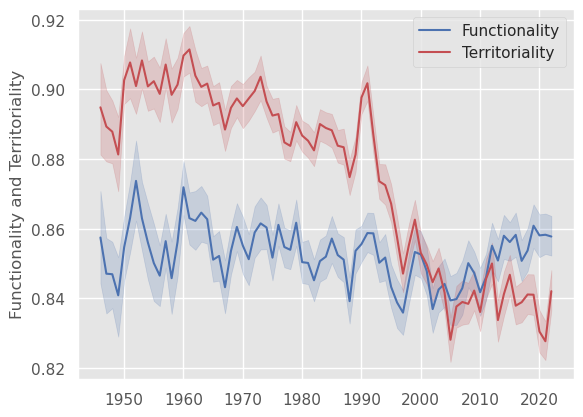

In [21]:
# # Add labels to the axes (optional)
ax=sns.lineplot(data=data_year, x="year", y="functionality_normalized", label='Functionality', color='b')

sns.lineplot(data=data_year, x="year", y="territoriality_normalized", color='r', label='Territoriality')
ax.set_ylabel('Functionality and Territoriality')
ax.set_xlabel(None)

plt.legend()
# Display the plot
plt.show()

### With Doc2Vec

In [55]:
data_year['tag']=(data_year['year']).astype(str)+'_'+data_year['country_name_short']
data_year

,country,text,year,country_name_short,UN_region,clean_text,clean_text_merged,territoriality_w2v_centroid,speech_w2v_centroid,functionality_w2v_centroid,territoriality_normalized,functionality_normalized,territorial_similarity_w2v,functional_similarity_w2v,tag
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile,South America,"[shall, occupy, rostrum, minute, order, genera...","[shall, occupy, rostrum, minute, order, genera...",0.650032,"[[0.044093523, -0.076105654, 0.07841529, -0.02...",0.626018,0.853600,0.846395,0.396386,0.345158,1946_Chile
1,COL,The Colombian delegation does not consider it ...,1946,Colombia,South America,"[colombian_delegation, doe_consider, necessary...","[colombian_delegation, doe_consider, necessary...",0.702724,"[[0.04283687, -0.0910701, 0.07819061, -0.05903...",0.647463,0.922793,0.875389,0.418466,0.357203,1946_Colombia
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus,Eastern Europe,"[elapsed, united_charter, signed_francisco, po...","[elapsed, united_charter, signed_francisco, po...",0.676654,"[[0.06574709, -0.093488194, 0.091779195, -0.07...",0.611234,0.888558,0.826407,0.406374,0.335559,1946_Belarus
3,IND,I stand before this great Assembly — unique in...,1946,India,Southern Asia,"[stand, great, unique_annals, human_history, r...","[stand, great, unique_annals, human_history, r...",0.689712,"[[0.082330756, -0.08206817, 0.06648913, -0.048...",0.645025,0.905705,0.872092,0.419993,0.353764,1946_India
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe,"[great, pronouncement, president_truman, used,...","[great, pronouncement, president_truman, used,...",0.662858,"[[0.05362493, -0.07696427, 0.062996045, -0.070...",0.631193,0.870443,0.853391,0.396430,0.342981,1946_United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10563,GAB,"It is my pleasant duty to offer you, Mr. Presi...",1963,Gabon,Middle Africa,"[pleasant_duty, offer, president_behalf, gabon...","[pleasant_duty, offer, president_behalf, gabon...",0.690761,"[[0.062194005, -0.082088776, 0.1025263, -0.024...",0.631161,0.907084,0.853348,0.408285,0.341656,1963_Gabon
10564,TCD,"It Is not without a certain pride, mixed with ...",1963,Chad,Middle Africa,"[certain, pride, mixed, speak_behalf, brings, ...","[certain, pride, mixed, speak_behalf, brings, ...",0.690995,"[[0.052766595, -0.07852616, 0.100937754, -0.03...",0.660515,0.907391,0.893035,0.406907,0.351140,1963_Chad
10565,COL,"Colombia, and the delegation which represents ...",1963,Colombia,South America,"[colombia, delegation, represents, particularl...","[colombia, delegation, represents, particularl...",0.721966,"[[0.062342923, -0.08467675, 0.09946557, -0.049...",0.695370,0.948060,0.940160,0.422449,0.372495,1963_Colombia
10566,TUN,"Mr. President, it is a pleasure for me first o...",1963,Tunisia,Northern Africa,"[president, pleasure_offer, behalf_behalf, tun...","[president, pleasure_offer, behalf_behalf, tun...",0.666594,"[[0.05606653, -0.058275696, 0.09744363, -0.029...",0.623406,0.875348,0.842863,0.402878,0.337566,1963_Tunisia


In [56]:
documents = [TaggedDocument(data_year['clean_text_merged'].iloc[k], [data_year['tag'].iloc[k]]) for k in tqdm(range(len(data_year)))]

model = Doc2Vec(documents, workers=10, vector_size=200, min_count=3, window=20, epochs=5)
fname = f"doc2vec_whole_corpus_year_country.model"
model.save(fname)

100%|██████████| 10556/10556 [00:00<00:00, 65579.39it/s]


In [57]:
territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

fname = f"doc2vec_whole_corpus_year_country.model"

d2v = Doc2Vec.load(fname)
words_frequency = joblib.load('wordscount_preprocess.pkl')

c_territorial_d2v=compute_centroids(d2v, territorial_terms, words_frequency)
c_functional_d2v=compute_centroids(d2v, functional_terms, words_frequency)

100%|██████████| 179902/179902 [00:00<00:00, 2883602.03it/s]


In [13]:
territoriality_d2v=[]
functionality_d2v=[]
for speech in data_year['clean_text_merged'].values:
    speech_centroid= compute_centroids(d2v, speech, words_frequency)
    similarity_territorial = cosine_similarity(speech_centroid, c_territorial_d2v)
    similarity_functional= cosine_similarity(speech_centroid, c_functional_d2v)

    territoriality_d2v.append(similarity_territorial)
    functionality_d2v.append(similarity_functional)
data_year['territoriality_d2v_centroid']=territoriality_d2v
data_year['functionality_d2v_centroid']=functionality_d2v

100%|██████████| 179902/179902 [00:00<00:00, 2785652.71it/s]
/tmp/ipykernel_3176/4242603960.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year['territoriality_d2v_centroid']=territoriality_d2v
/tmp/ipykernel_3176/4242603960.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year['functionality_d2v_centroid']=functionality_d2v


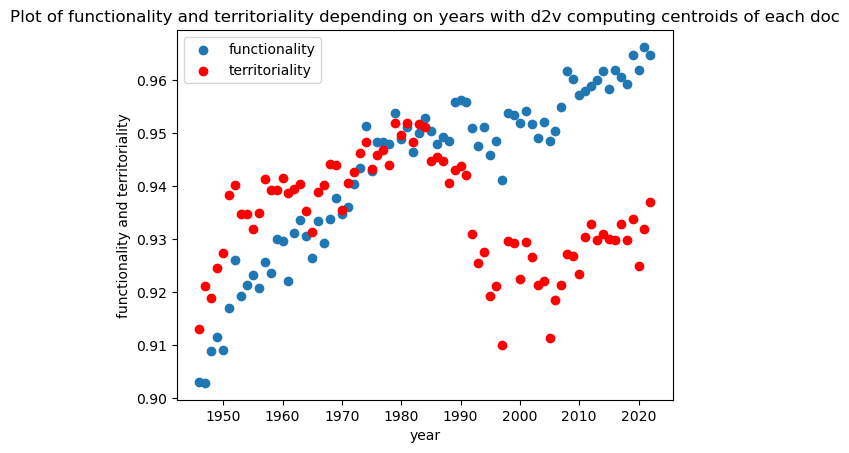

In [14]:
plt.scatter(data_year['year'], data_year['functionality_d2v_centroid'], marker='o', label='functionality')
plt.scatter(data_year['year'], data_year['territoriality_d2v_centroid'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality depending on years with d2v computing centroids of each doc')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()

## Unguided analysis (PCA)

### With Doc2Vec

In [16]:
data_year['speech_embedding_d2v']=data_year['year'].progress_apply(lambda x: model.dv[x])

100%|██████████| 77/77 [00:00<00:00, 101210.09it/s]
/tmp/ipykernel_3176/2312222166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_year['speech_embedding_d2v']=data_year['year'].progress_apply(lambda x: model.dv[x])


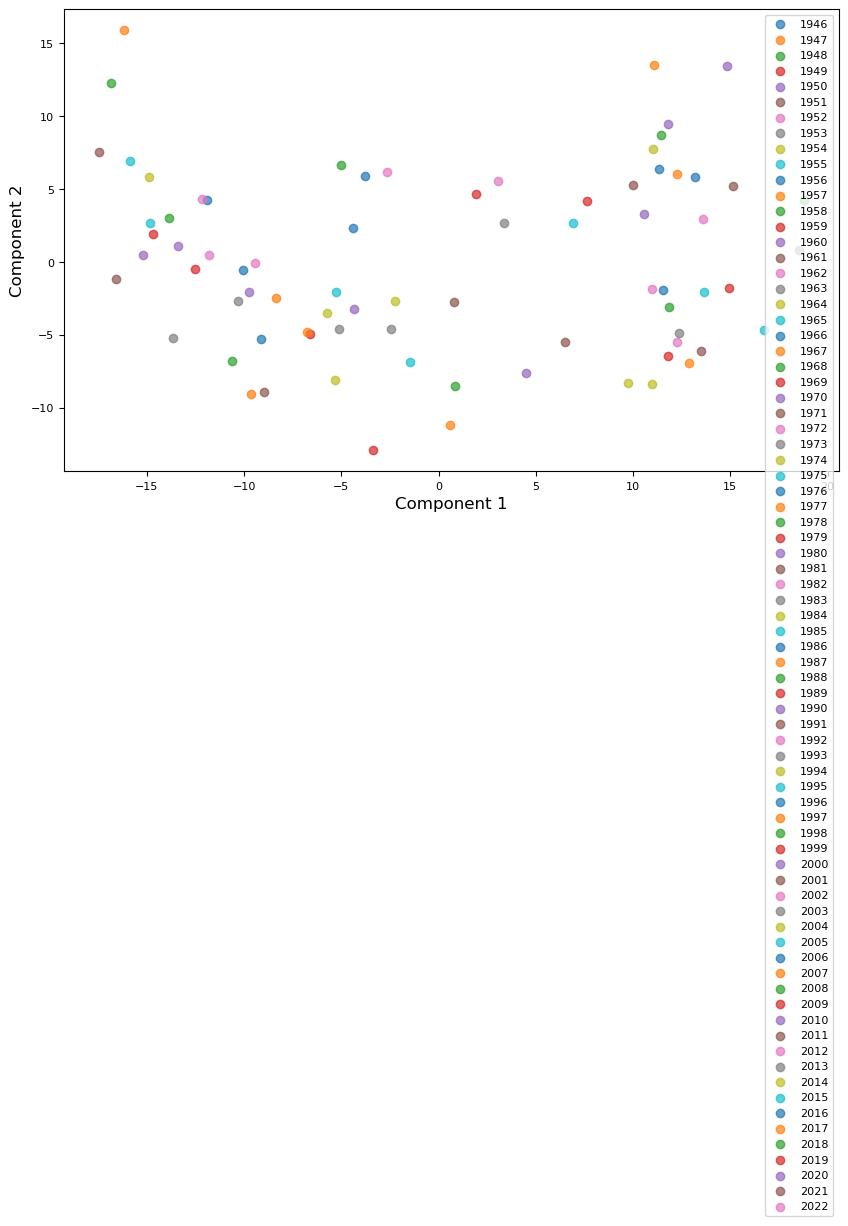

In [119]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['speech_embedding_d2v'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(data_year)

def project_pca(df_subset):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(df_subset['speech_embedding_d2v'].tolist())
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}
for year in set(data_year['year'].values):
    # Filtrer les données pour la famille actuelle
    data = data_year.loc[data_year['year']==year].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data)
    pca_comp_1[year]=(projections_2D[:,0])
    pca_comp_2[year]=(projections_2D[:,1])
    # Créer un graphique en nuage de points pour la famille actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=year)
    
data_year['PCA_component1_d2v']=data_year['year'].map(pca_comp_1)
data_year['PCA_component2_d2v']=data_year['year'].map(pca_comp_2)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)

# Ajouter une légende
ax.legend()
plt.savefig('PCA_whole_corpus_year_d2v.png')
# Afficher le graphique
plt.show()


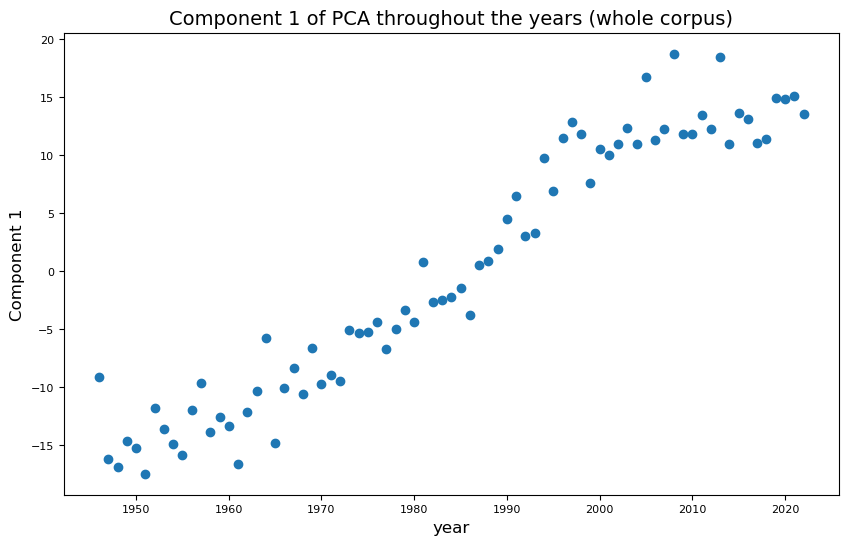

In [120]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_year['year'],data_year['PCA_component1_d2v'])
ax.set_title('Component 1 of PCA throughout the years (whole corpus)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.set_ylabel('Component 1', fontsize=12)
plt.show()

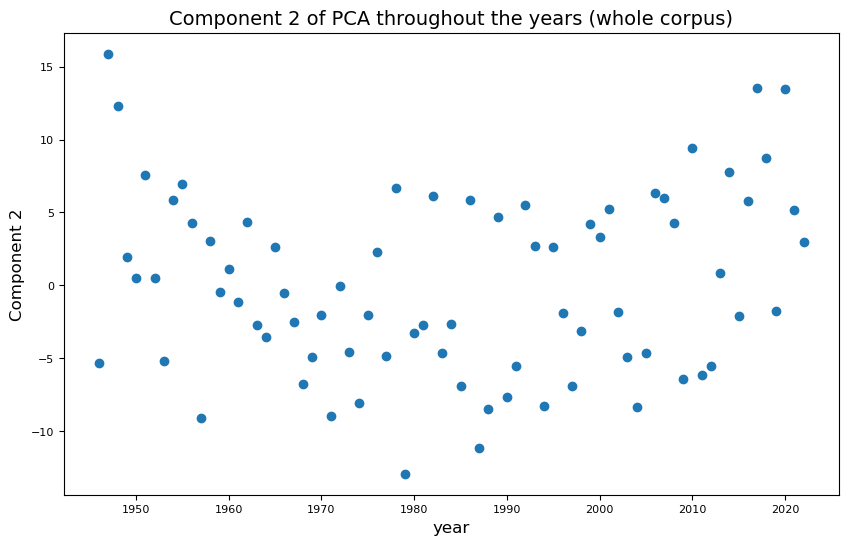

In [121]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_year['year'],data_year['PCA_component2_d2v'])
ax.set_title('Component 2 of PCA throughout the years (whole corpus)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)
plt.show()

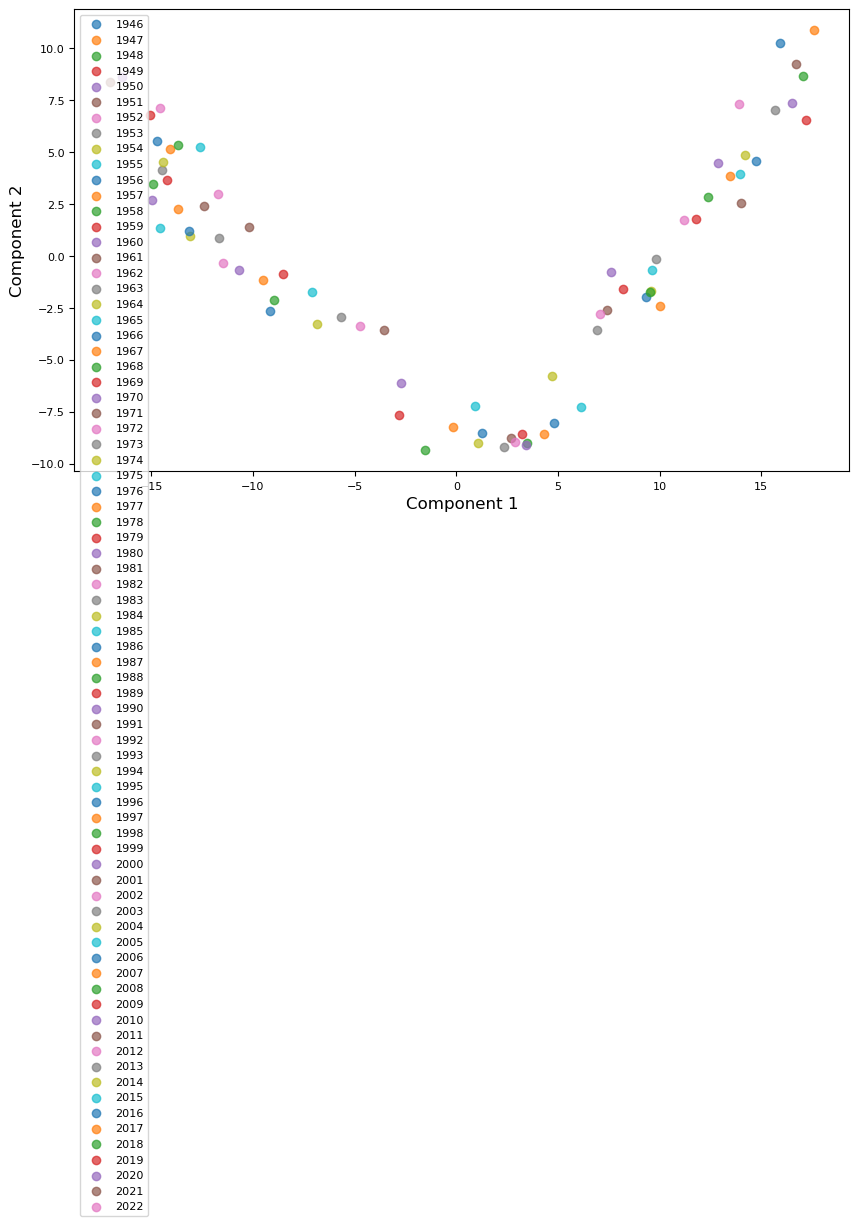

In [131]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

data_year['pca_w2v_embeddings']=data_year.apply(lambda x: np.squeeze(x['speech_w2v_centroid']), axis=1)


# Function to perform PCA
def perform_pca(data):
    # Convert the embeddings to a numpy array
    X = np.array(data['pca_w2v_embeddings'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(data_year)

def project_pca(data_list):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(data_list)
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

pca_comp_1={}
pca_comp_2={}
for year in set(data_year['year'].values):
    # Filtrer les données pour la famille actuelle
    data = data_year.loc[data_year['year']==year].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = project_pca(data['pca_w2v_embeddings'].tolist())
    pca_comp_1[year]=(projections_2D[:,0])
    pca_comp_2[year]=(projections_2D[:,1])
    # Créer un graphique en nuage de points pour la famille actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=year)
    
data_year['PCA_component1_w2v']=data_year['year'].map(pca_comp_1)
data_year['PCA_component2_w2v']=data_year['year'].map(pca_comp_2)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)

# Ajouter une légende
ax.legend()
plt.savefig('PCA_data_by_region.png')
# Afficher le graphique
plt.show()


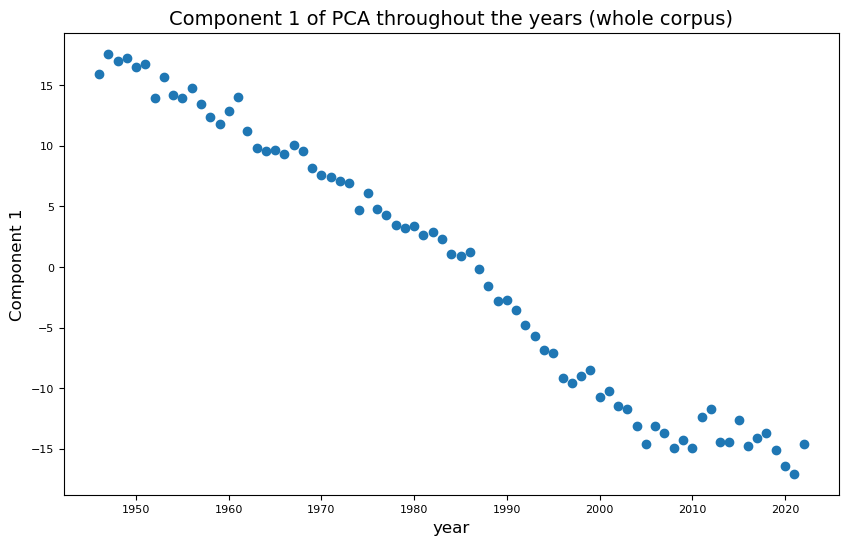

In [123]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_year['year'],data_year['PCA_component1_w2v'])
ax.set_title('Component 1 of PCA throughout the years (whole corpus)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.set_ylabel('Component 1', fontsize=12)
plt.show()

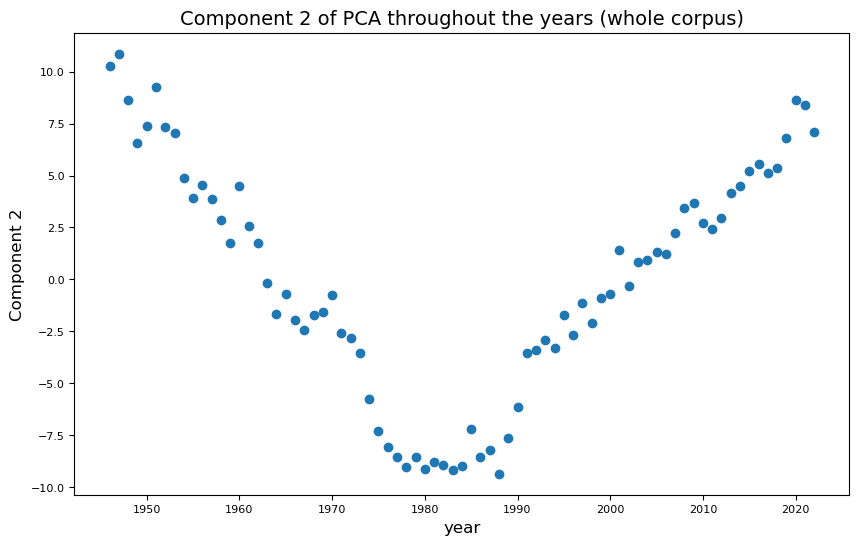

In [124]:
# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_year['year'],data_year['PCA_component2_w2v'])
ax.set_title('Component 2 of PCA throughout the years (whole corpus)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('year', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)
plt.show()

In [150]:
model = w2v
list_words=model.wv.index_to_key
list_word_embdeds=[model.wv[word] for word in list_words]
# Extract PCA component 1 scores for all words
word_pca_scores = project_pca(list_word_embdeds)[:, 0]

# Sort words based on PCA component 1 scores in descending order
sorted_word_indices = np.argsort(word_pca_scores)[::-1]
sorted_words = [list_words[i] for i in sorted_word_indices]

# Select top N words with highest PCA component 1 scores
top_n = 20
top_words = sorted_words[:top_n]
print("Top {} words with highest PCA component 1 scores:".format(top_n))
for word in top_words:
    print(word)

Top 20 words with highest PCA component 1 scores:
president_gaulle
yugoslav
vyshinsky
germany
western_power
ussr_delegation
propaganda
principle_self
israel
warmonger
west_german
yugoslav_delegation
ussr
greek_people
nazi
prohibition_atomic
alleged
eban
german
communist


In [151]:
list_words=model.wv.index_to_key
list_word_embdeds=[model.wv[word] for word in list_words]
# Extract PCA component 1 scores for all words
word_pca_scores = project_pca(list_word_embdeds)[:, 1]

# Sort words based on PCA component 1 scores in descending order
sorted_word_indices = np.argsort(word_pca_scores)[::-1]
sorted_words = [list_words[i] for i in sorted_word_indices]

# Select top N words with highest PCA component 1 scores
top_n = 20
top_words = sorted_words[:top_n]
print("Top {} words with highest PCA component 2 scores:".format(top_n))
for word in top_words:
    print(word)

Top 20 words with highest PCA component 2 scores:
mother_earth
speech
remember
school
congress
american
ambassador
palau
told
canada
canadian
united_state
kiribati
message
churchill
department
moon
care
official
family


## Average similarity of each word embedding with seed vector 

Here we first compute the average embedding of each list of seed words, then the average similarity of the words of the row with the seed vector 

### With Word2Vec

In [50]:
tokenized_corpus = data_year['clean_text_merged'].values
model=w2v
# Seed words

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

seed_words = territorial_terms + functional_terms

# Calculate average vector for seed words
territorial_seed_vectors = sum([model.wv[word] for word in territorial_terms if word in model.wv.index_to_key]) / len(territorial_terms)
functional_seed_vectors = sum([model.wv[word] for word in functional_terms if word in model.wv.index_to_key]) / len(functional_terms)

In [51]:
def cosine_similarity_row(row, ref_vector):
    # Extract vectors for words that are in the model's vocabulary
    word_vectors = np.array(
        [model.wv[word] for word in row if word in model.wv.index_to_key]
    )
    # Calculate cosine similarity for the word vectors against the reference vector
    similarities = cosine_similarity(word_vectors, [ref_vector])
    # Compute the average cosine similarity
    average_similarity = np.mean(similarities)
    return average_similarity

In [52]:
# Calculate cosine similarity between average embeddings and all embedded speeches

data_year['territorial_similarity_w2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, territorial_seed_vectors))
data_year['functional_similarity_w2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, functional_seed_vectors))

100%|██████████| 10556/10556 [30:56<00:00,  5.69it/s] 


/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.

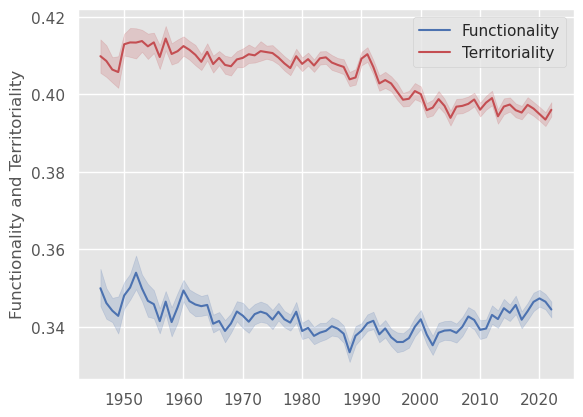

In [54]:

# # Add labels to the axes (optional)
ax=sns.lineplot(data=data_year, x="year", y="functional_similarity_w2v", label='Functionality', color='b')

sns.lineplot(data=data_year, x="year", y="territorial_similarity_w2v", color='r', label='Territoriality')
ax.set_ylabel('Functionality and Territoriality')
ax.set_xlabel(None)

plt.legend()
# Display the plot
plt.show()

In [31]:
model=w2v

# Calculate semantic similarity between each word in the vocabulary and seed words
word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
word_similarities = {}

for word, vector in word_vectors.items():
    territorial_similarity = cosine_similarity([vector], [territorial_seed_vectors])[0][0]
    functional_similarity = cosine_similarity([vector], [functional_seed_vectors])[0][0]
    word_similarities[word] = (territorial_similarity, functional_similarity)

In [32]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][0]), reverse=True)
top_20_words_territorial = sorted_word_similarities[:30]

top_territorial=[word for word, (func_sim, terr_sim) in top_20_words_territorial[:30]]

print("Top 30 words related to high territorial terms:", top_territorial)

Top 30 words related to high territorial terms: ['destroyed', 'money_spent', 'feed', 'banish', 'unimaginable', 'tentacle', 'disappearing', 'horrible', 'people_died', 'civil_war', 'deadly', 'fast', 'occurring', 'crushing_burden', 'getting', 'leaving', 'sophisticated', 'irrational', 'caught', 'awful', 'shared_prosperity', 'plague', 'poisoned', 'disruption', 'poverty_misery', 'reached_level', 'multiply', 'recruit', 'helpless', 'wind']


In [33]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][1]), reverse=True)
top_20_words_functional = sorted_word_similarities[:30]

top_functional=[word for word, (func_sim, terr_sim) in top_20_words_functional[:30]]

print("Top 30 words related to high functional terms:", top_functional)

Top 30 words related to high functional terms: ['crushing_burden', 'shared_prosperity', 'poverty_misery', 'banish', 'protect_environment', 'nascent', 'caring', 'disappearing', 'occurring', 'sophisticated', 'child_dying', 'virus', 'tuberculosis', 'annually', 'luxury', 'hunger_poverty', 'wealthy', 'money_spent', 'suffer_hunger', 'better_health', 'hungry', 'improved_health', 'economic_model', 'fewer', 'unemployed', 'starving', 'heal', 'forgiveness', 'transform_life', 'save_humankind']


### With Doc2Vec

In [58]:
tokenized_corpus = data_year['clean_text_merged'].values
model=d2v
# Seed words

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

seed_words = territorial_terms + functional_terms

# Calculate average vector for seed words
territorial_seed_vectors = sum([model.wv[word] for word in territorial_terms if word in model.wv.index_to_key]) / len(territorial_terms)
functional_seed_vectors = sum([model.wv[word] for word in functional_terms if word in model.wv.index_to_key]) / len(functional_terms)

In [59]:
def cosine_similarity_row(row, ref_vector):
    # Extract vectors for words that are in the model's vocabulary
    word_vectors = np.array(
        [model.wv[word] for word in row if word in model.wv.index_to_key]
    )
    # Calculate cosine similarity for the word vectors against the reference vector
    similarities = cosine_similarity(word_vectors, [ref_vector])
    # Compute the average cosine similarity
    average_similarity = np.mean(similarities)
    return average_similarity

In [60]:
# Calculate cosine similarity between average embeddings and all embedded speeches

data_year['territorial_similarity_d2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, territorial_seed_vectors))
data_year['functional_similarity_d2v'] = data_year['clean_text_merged'].progress_apply(lambda x: cosine_similarity_row(x, functional_seed_vectors))

100%|██████████| 10556/10556 [28:56<00:00,  6.08it/s]


/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jahandelestangjim/miniconda3/envs/datasetconversion/lib/python3.

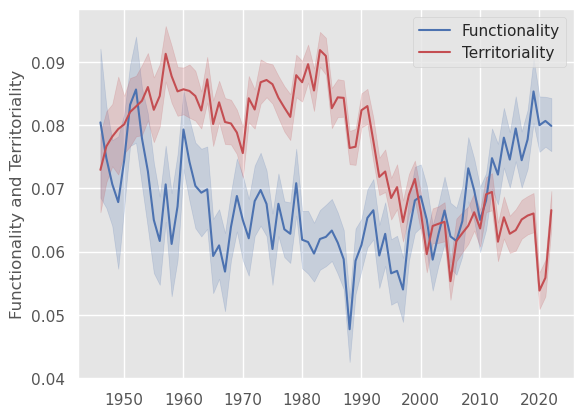

In [61]:

# # Add labels to the axes (optional)
ax=sns.lineplot(data=data_year, x="year", y="functional_similarity_d2v", label='Functionality', color='b')

sns.lineplot(data=data_year, x="year", y="territorial_similarity_d2v", color='r', label='Territoriality')
ax.set_ylabel('Functionality and Territoriality')
ax.set_xlabel(None)

plt.legend()
# Display the plot
plt.show()

In [28]:
model=d2v

# Calculate semantic similarity between each word in the vocabulary and seed words
word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
word_similarities = {}

for word, vector in word_vectors.items():
    territorial_similarity = cosine_similarity([vector], [territorial_seed_vectors])[0][0]
    functional_similarity = cosine_similarity([vector], [functional_seed_vectors])[0][0]
    word_similarities[word] = (territorial_similarity, functional_similarity)

In [29]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][0]), reverse=True)
top_20_words_territorial = sorted_word_similarities[:30]

top_territorial=[word for word, (func_sim, terr_sim) in top_20_words_territorial[:30]]

print("Top 30 words related to high territorial terms:", top_territorial)

Top 30 words related to high territorial terms: ['grip', 'south_asia', 'establishment_diplomatic', 'especially_true', 'source_tension', 'enclave', 'sided', 'interruption', 'erupted', 'relation_neighbouring', 'emigration', 'salvador', 'indian_ocean', 'danger_posed', 'neighbouring_country', 'poverty_disease', 'central_america', 'breeding_ground', 'consolidated', 'concentrating_effort', 'converting', 'cross_border', 'looming', 'destabilizing', 'unbearable', 'flooding', 'member_association', 'fertilizer', 'privation', 'stability_security']


In [30]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][1]), reverse=True)
top_20_words_functional = sorted_word_similarities[:30]

top_functional=[word for word, (func_sim, terr_sim) in top_20_words_functional[:30]]

print("Top 30 words related to high functional terms:", top_functional)

Top 30 words related to high functional terms: ['natural_resource', 'science', 'main_goal', 'beneficiary', 'develop', 'information_technology', 'dividend', 'domestic', 'rich', 'decrease', 'translated', 'right_track', 'scale', 'social_condition', 'alike', 'money', 'deficit', 'national_economy', 'healthy', 'growing', 'compensate', 'discriminatory', 'link', 'ethnic_cultural', 'malnutrition', 'enormous', 'barrier', 'fostered', 'doe_lead', 'grow']


## Guided projections territoriality-functionality

### D2V

Text(0.5, 1.0, 'Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)')

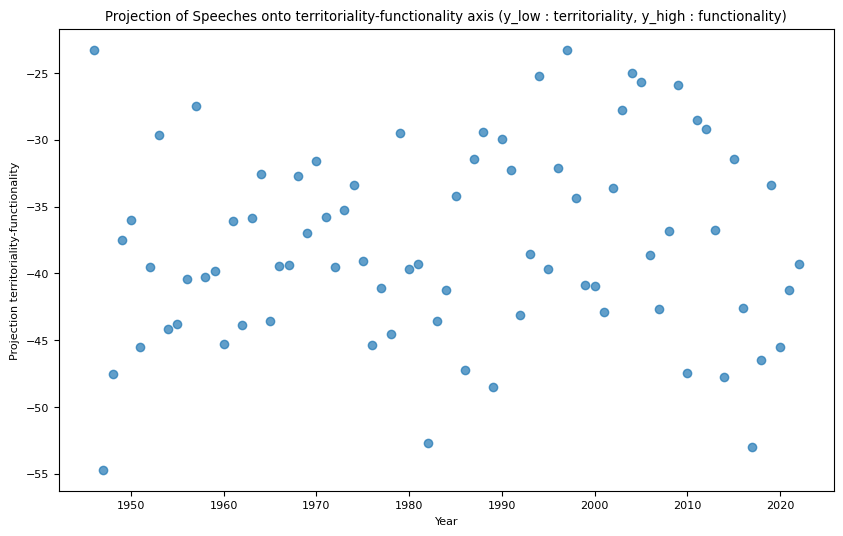

In [106]:
model=d2v

lex = [territorial_terms, functional_terms] 

def linear_projection_1D(pVec, vecXLeft, vecXRight):    
    vecX = vecXRight.mean(axis=0) - vecXLeft.mean(axis=0) 
    return np.dot(pVec, vecX)  

def get_vector(model, words, num_features=200): 
    words = [w for w in words if w in model.wv.index_to_key]
    L = len(words)
    temp = np.zeros((L, num_features))
    for i, x in enumerate(words):
        temp[i,:] = model.wv[x]
    return temp

def custom_projection_1D(z, model):
    M = model.vector_size
    x_terr, x_func = [get_vector(model, words, M) for words in lex] 
    projections = [linear_projection_1D(x, x_terr, x_func) for x in z]
    Z = np.array(projections) 
    return Z

# Définir la taille de la police de caractère
plt.rcParams.update({'font.size': 8})

# Trier les données par année
df_sorted = data_year.sort_values(by=['year'])

# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

projections_1D = custom_projection_1D(df_sorted['speech_embedding_d2v'].values, model)

# Créer un graphique en nuage de points pour la famille actuelle
ax.scatter(df_sorted['year'], projections_1D, alpha=0.7)

# Label the axes
plt.xlabel("Year")
plt.ylabel("Projection territoriality-functionality")
plt.title("Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)")

### W2V

Text(0.5, 1.0, 'Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)')

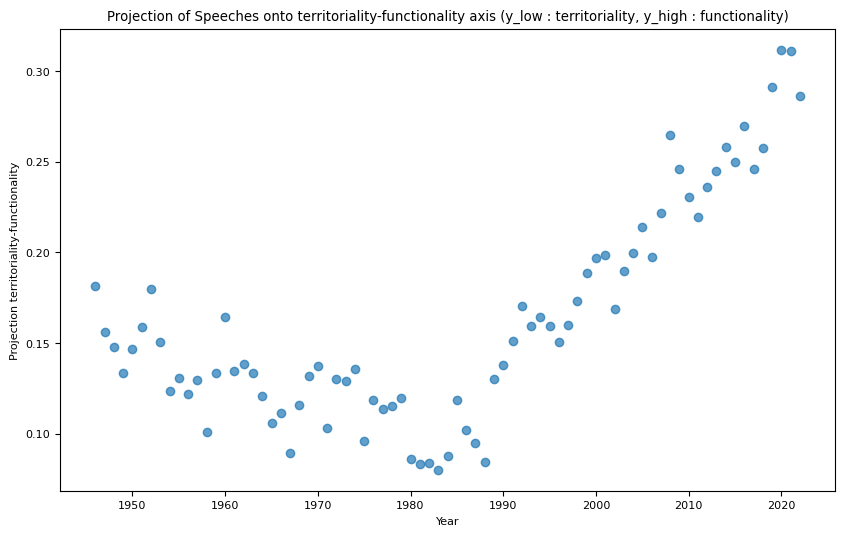

In [109]:
model=w2v

lex = [territorial_terms, functional_terms] 

# Définir la taille de la police de caractère
plt.rcParams.update({'font.size': 8})

# Trier les données par année
df_sorted = data_year.sort_values(by=['year'])

# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

projections_1D = custom_projection_1D(df_sorted['speech_w2v_centroid'].values, model)

# Créer un graphique en nuage de points pour la famille actuelle
ax.scatter(df_sorted['year'], projections_1D, alpha=0.7)

# Label the axes
plt.xlabel("Year")
plt.ylabel("Projection territoriality-functionality")
plt.title("Projection of Speeches onto territoriality-functionality axis (y_low : territoriality, y_high : functionality)")

In [ ]:
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


def topic_vectors(topicwords, model, n=20):
    M = model.vector_size
    centroids = []

    # Compute the centroid for each topic word and store them in a list
    for topicword in topicwords:
        sims = model.wv.most_similar(topicword, topn=n)
        simw = [topicword] + [w for w, s in sims]
        zsim = np.zeros((n + 1, M))
        for i, w in enumerate(simw):
            zsim[i, :] = model.wv[w]
        centroids.append(zsim.mean(axis=0))

    # Calculate the average centroid across all topic words
    overall_centroid = np.mean(centroids, axis=0)
    return overall_centroid

def bootstrap_topic_vectors(topicwords, model, n=20, sims=1000):
    M = model.vector_size
    boot_results = np.zeros((sims, M))
    
    # Get all topic words to be used in bootstrapping
    topic_words = []
    for topicword in topicwords:
        expanded_word_list = model.wv.most_similar(topicword, topn=n - 1)
        topic_words.extend([topicword] + [w for w, s in expanded_word_list])
    
    # Perform bootstrapping to calculate centroids
    for s in range(sims):
        boot_sample = np.random.choice(topic_words, size=n, replace=True)
        zsim = np.zeros((n, M))
        for i, w in enumerate(boot_sample):
            zsim[i, :] = model.wv[w]
        boot_results[s, :] = zsim.mean(axis=0)

    return boot_results

def cos_sim(speech, topic, boot=True, sims=1000):
    P = speech.shape[0]
    if boot:
        C = cosine_similarity(speech, topic)
        m = np.mean(C, axis=1)
        ci = np.percentile(C, q=[2.5, 97.5], axis=1)
        return m.tolist(), ci[0].tolist(), ci[1].tolist()
    else:
        return cosine_similarity(speech, topic).tolist()

def issue_ownership(model, topicwords, infer_vector=True, t_size=20, boot=True, smooth=True):
    # Get the average centroid for the list of topic words
    if infer_vector:
        if boot:
            t = bootstrap_topic_vectors(topicwords, model, n=t_size, sims=1000)
        else:
            t = topic_vectors(topicwords, model, n=t_size)
    else:
        raise ValueError("Either topic words or topic vectors must be provided")

    res = fit(model, t, smooth=smooth, boot=boot)
    return res

def fit(model, topic_vector, smooth=False, boot=True):
    M = model.vector_size
    years = sorted(list(set(data_embed['year'].values)))
    P = len(years)
    z = np.zeros((P, M))

    # Populate `z` with document vectors for each year
    for i, year in enumerate(years):
        doc_index = next((index for (index, (doc, tag)) in enumerate(documents) if tag == [year]), None)
        if doc_index is not None:
            z[i, :] = model.dv[doc_index]
    
    # Calculate similarity and return results
    C = cos_sim(z, topic_vector, boot=boot)
    res = pd.DataFrame({'year': years, 'similarity': C[0]})

    if smooth:
        res = res.rolling(window=10, center=False).mean()
        res['year'] = years

    return res


In [ ]:
sims = model.wv.most_similar('territorial', topn = 10)
sims

In [ ]:
corpus_trends=pd.DataFrame()
corpus_functional_sim=issue_ownership(model, topicwords=functional_terms, smooth=False, boot=True)
corpus_territorial_sim=issue_ownership(model, topicwords=territorial_terms, smooth=False, boot=True)

corpus_trends['year']=corpus_functional_sim['year']
corpus_trends['functionality']=corpus_functional_sim['similarity']
corpus_trends['territoriality']=corpus_territorial_sim['similarity']
plt.plot(corpus_trends['year'], corpus_trends['functionality'], marker='o', label='functionality')
plt.plot(corpus_trends['year'], corpus_trends['territoriality'], marker='o', color='r', label='territoriality')

# Set the plot title
plt.title('Plot of functionality and territoriality depending on years')

# Add labels to the axes (optional)
plt.xlabel('year')
plt.ylabel('functionality and territoriality')

plt.legend()
# Display the plot
plt.show()